In [ ]:
install.packages("GGally")

In [1]:
library(tidyverse)
library(patchwork)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Chest Pain Classification Using K-Nearest Neighbors
Section 003, Group 21

## **Introduction**
Heart disease refers to a range of conditions that affect the heart. Various factors, such as age, lifestyle, and genetics, can influence the chances of an individual getting heart disease. We want to understand what factors are related to certain chest pain types. <br>

**Research Question:**
Can we determine what type of chest pain a patient is likely experiencing based on their age, cholesterol, resting and max heart rates, ST-depression, exercise angina, and diagnosis?

The dataset that we will be using is titled “Heart Disease”.  It contains observations with a total of 76 attributes, collected from various patients. These observations have been processed and published as 4 experiment databases, each including the same subset of 14 attributes. For ease of reading, we chose to use the processed experiment files for our data.

## **Preliminary Analysis**
To read the data, we first downloaded the data set.  We then looked through the files and realized that only the processed data was likely to be readable with our current knowledge, and thus chose to use the 4 processed files. <br>
After reading the files and looking through the heart-disease.names file for the descriptions of each attribute, we gave the table columns appropriate names to ensure the data would be understandable. <br>
Below is the original data with added column names:


In [2]:
hungarian_data <- read_delim("processed.hungarian.data", delim = ",", col_names = FALSE)
colnames(hungarian_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

cleveland_data <- read_delim("processed.cleveland.data", delim = ",", col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

switzerland_data <- read_delim("processed.switzerland.data", delim = ",", col_names = FALSE)
colnames(switzerland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

va_data <- read_delim("processed.va.data", delim = ",", col_names = FALSE)
colnames(va_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

stacked_data <- rbind(hungarian_data, va_data, switzerland_data, cleveland_data)
head(stacked_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


**Beginning of Tidying**
***

In [3]:
editedData <- stacked_data

idx <- editedData == "?"
# replace "?" values with NA
is.na(editedData) <- idx

navalues <- colSums(is.na(editedData))
navalues

age                     sex         chest_pain_type 
                      0                       0                       0 
                rest_bp       serum_cholesterol              fasting_bs 
                     59                      30                      90 
       rest_ecg_results           max_heartrate         exercise_angina 
                      2                      55                      55 
          st_depression              slope_type num_coloured_flourosopy 
                     62                     309                     611 
                   thal               diagnosis 
                    486                       0

In [4]:
#Removing columns with too many NA values and then removing observations with NA
editedData <- editedData |>
    select(-slope_type, -num_coloured_flourosopy, -thal) |>
    na.omit()

In [17]:
for(i in 1:nrow(editedData)) {       # for-loop over rows
    if(editedData$sex[i] == 1){
      editedData$sex[i] <- "Male"
    }else{
      editedData$sex[i]<- "Female"
      }
    
    if(editedData$chest_pain_type[i] == 1){
      editedData$chest_pain_type[i] <- "Typical Angina"
    }

    if(editedData$chest_pain_type[i] == 2){
      editedData$chest_pain_type[i] <- "Atypical Angina"
    }

    if(editedData$chest_pain_type[i] == 3){
      editedData$chest_pain_type[i] <- "Non-Anginal Pain"
    }

    if(editedData$chest_pain_type[i] == 4){
      editedData$chest_pain_type[i] <- "Asymptomatic"
    }

    if(editedData$diagnosis[i] == 0){
      editedData$diagnosis[i] <- "< 50% Diameter Narrowing"
    }else{
      editedData$diagnosis[i] <- "> 50% Diameter Narrowing"
    }  

    if(!is.na(editedData$rest_ecg_results[i])){
       if(editedData$rest_ecg_results[i] == 0){
          editedData$rest_ecg_results[i] <- "Normal"
             }
    
        if(editedData$rest_ecg_results[i] == 1){
          editedData$rest_ecg_results[i] <- "ST-T Wave Abnormality"
             }
    
         if(editedData$rest_ecg_results[i] == 2){
          editedData$rest_ecg_results[i] <- "Probable or Definite Left Ventricular Hypertrophy"
             }
        
        }

 if(!is.na(editedData$fasting_bs[i])){

    if(editedData$fasting_bs[i] == 0){
          editedData$fasting_bs[i] <- "False"
             }
    
    if(editedData$fasting_bs[i] == 1){
          editedData$fasting_bs[i] <- "True"
             }
     }

    
     if(!is.na(editedData$exercise_angina[i])){
        if(editedData$exercise_angina[i] == 0){
              editedData$exercise_angina[i] <- "No"
                 }
        
        if(editedData$exercise_angina[i] == 1){
              editedData$exercise_angina[i] <- "Yes"
                 }
         }

#    if(!is.na(editedData$thal[i])){
#        if(editedData$thal[i] == 3){editedData$thal[i] <- "normal"}
#        
#        if(editedData$thal[i] == 6){editedData$thal[i] <- "fixed defect"}
#         
#        if(editedData$thal[i] == 7){editedData$thal[i] <- "reversable defect"}
#             }
    

#     if(!is.na(editedData$slope_type[i])){
#       if(editedData$slope_type[i] == 1){editedData$slope_type[i] <- "upsloping"}
#    
#       if(editedData$slope_type[i] == 2){editedData$slope_type[i] <- "flat"}
#    
#       if(editedData$slope_type[i] == 3){editedData$slope_type[i] <- "downsloping"}
#        }

}

In [6]:
#Removing incorrect 0 values
editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)

In [7]:
#Changing data types
editedData <- editedData |>
    mutate(sex = as.factor(sex)) |>
    mutate(chest_pain_type = as.factor(chest_pain_type)) |>
    mutate(rest_bp = as.numeric(rest_bp)) |>
    mutate(fasting_bs = as.factor(fasting_bs)) |>
    mutate(rest_ecg_results = as.factor(rest_ecg_results)) |>
    mutate(max_heartrate = as.numeric(max_heartrate)) |>
    mutate(exercise_angina = as.factor(exercise_angina)) |>
    mutate(st_depression = as.numeric(st_depression)) |>
    mutate(diagnosis = as.factor(diagnosis))
#unique(editedData$predictor)

***
**End of Tidying** <br>

After summarizing the data for our analysis and tidying the data, our new data set looks like this:

In [8]:
head(editedData)

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
28,Male,Atypical Angina,130,132,False,Probable or Definite Left Ventricular Hypertrophy,185,No,0,< 50% Diameter Narrowing
29,Male,Atypical Angina,120,243,False,Normal,160,No,0,< 50% Diameter Narrowing
30,Female,Typical Angina,170,237,False,ST-T Wave Abnormality,170,No,0,< 50% Diameter Narrowing
31,Female,Atypical Angina,100,219,False,ST-T Wave Abnormality,150,No,0,< 50% Diameter Narrowing
32,Female,Atypical Angina,105,198,False,Normal,165,No,0,< 50% Diameter Narrowing
32,Male,Atypical Angina,110,225,False,Normal,184,No,0,< 50% Diameter Narrowing


To determine which variables might show useful differentiation between the types of pain, we created several scatter and bar plots as seen below. Note that scatter plots were used to visualize the distribution of numeric values rather than histograms, as creating separate histograms for each predictor would have resulted in a large and difficult to interpret group of charts.

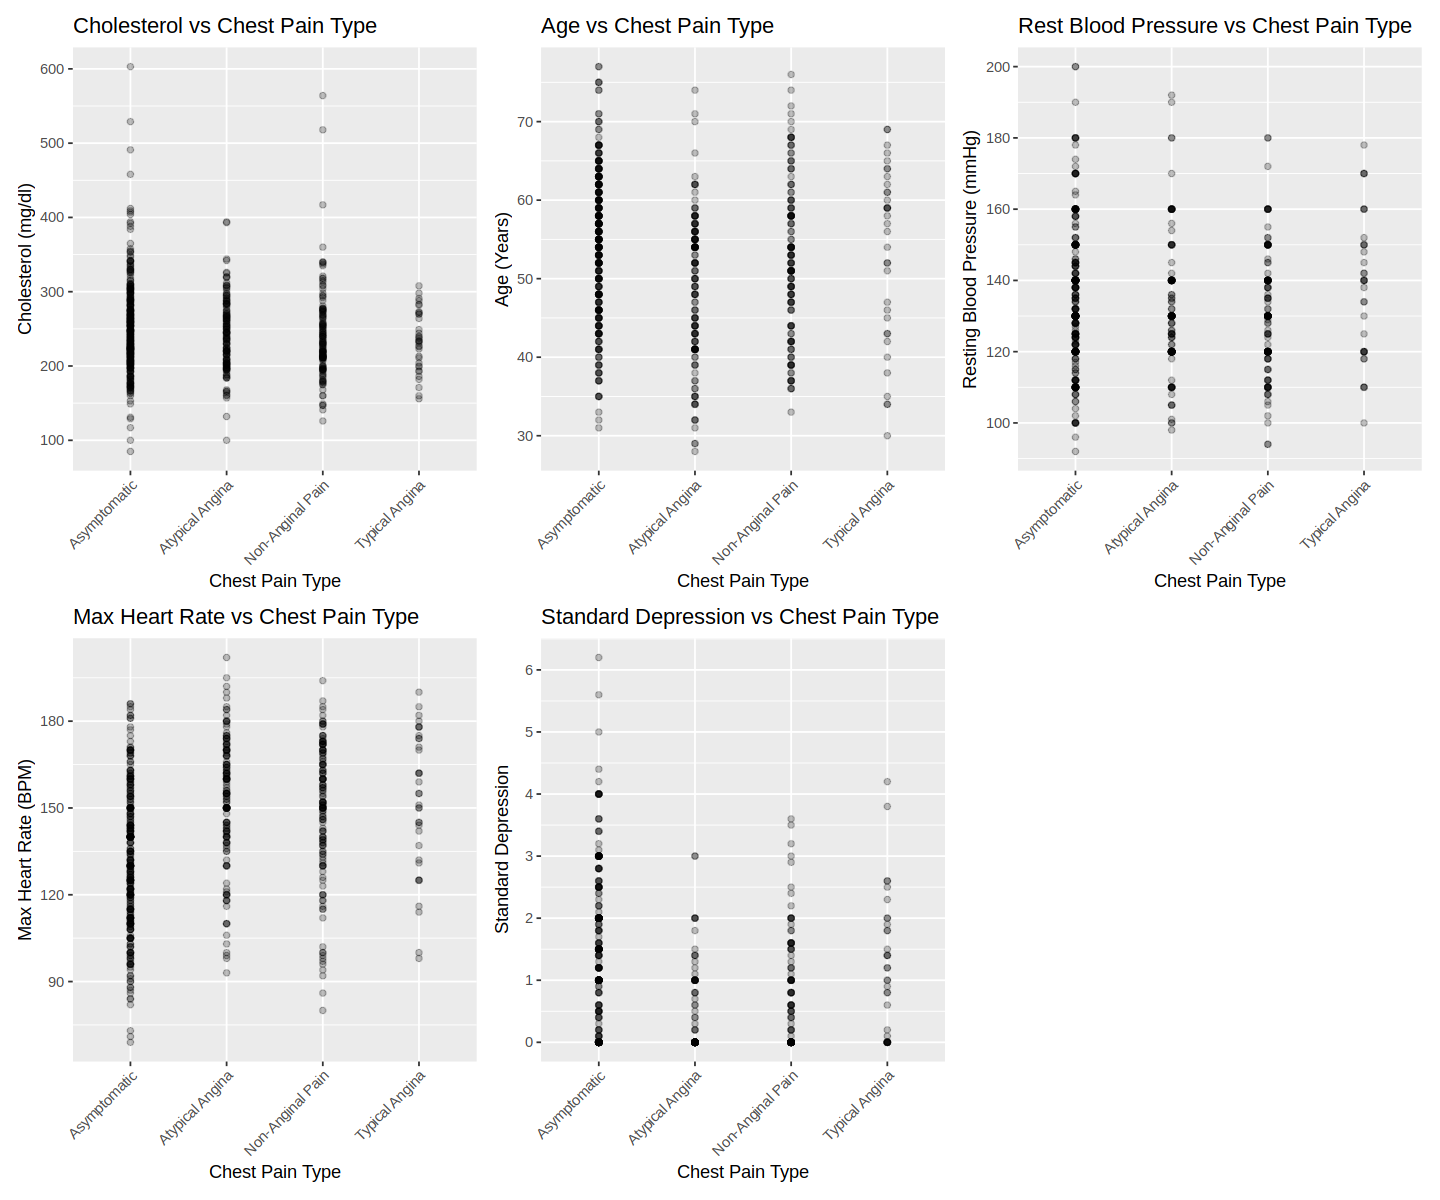

In [9]:
#Making scatter Plot

options(repr.plot.height = 10, repr.plot.width = 12)
#serum_cholesterol, age, rest_bp, max_heartrate

PainVsSerum <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = as.numeric(serum_cholesterol))) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Cholesterol vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Cholesterol (mg/dl)", breaks = seq(0, 700, by = 100)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsAge <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = age)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Age vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Age (Years)", breaks = seq(0, 100, by = 10)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsRHR <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = rest_bp)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Rest Blood Pressure vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Resting Blood Pressure (mmHg)", breaks = seq(0, 200, by = 20)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsMHR <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = max_heartrate)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Max Heart Rate vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Max Heart Rate (BPM)", breaks = seq(0, 300, by = 30)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsDepression <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = st_depression)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Standard Depression vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Standard Depression", breaks = seq(0, 10, by = 1)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsSerum + PainVsAge + PainVsRHR + PainVsMHR + PainVsDepression + 
  plot_layout(ncol = 3)

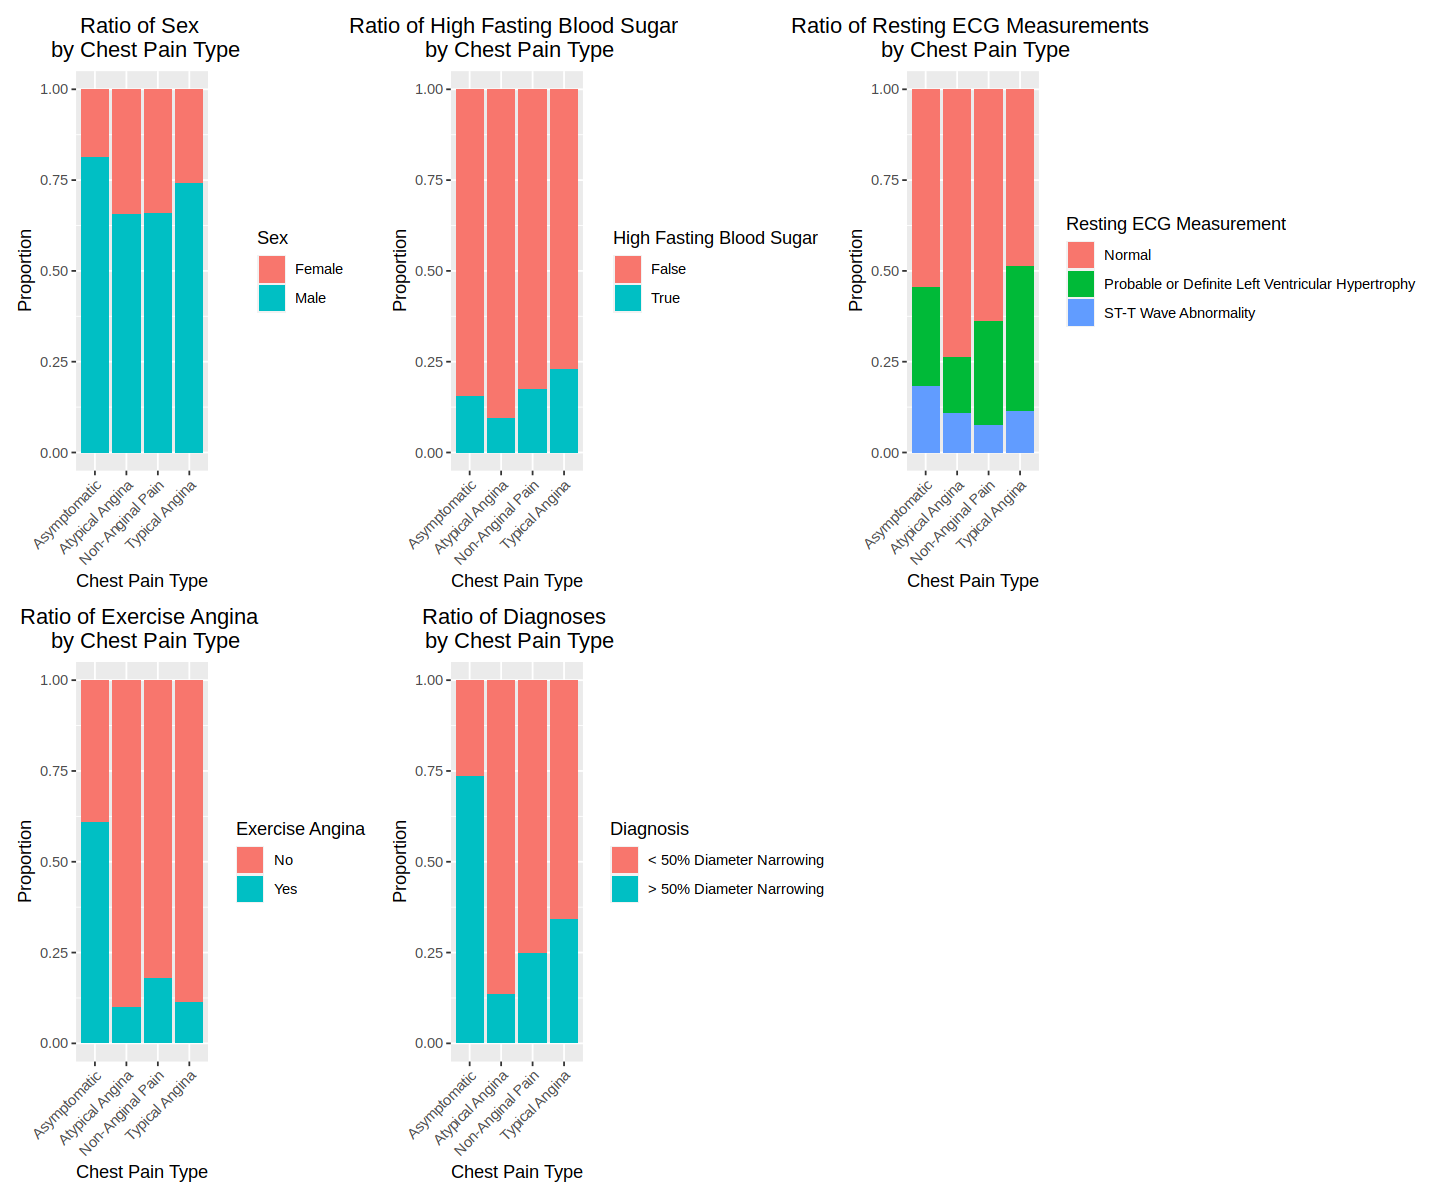

In [15]:
#Making bar plots
PainVsSex <- editedData |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = sex)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Sex \n by Chest Pain Type", fill = "Sex")

PainVsFastingBS <- editedData |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = fasting_bs)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of High Fasting Blood Sugar \n by Chest Pain Type", fill = "High Fasting Blood Sugar")

PainVsRestECG <- editedData |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = rest_ecg_results)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Resting ECG Measurements \n by Chest Pain Type", fill = "Resting ECG Measurement")

PainVsExerciseAngina <- editedData |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = exercise_angina)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Exercise Angina \n by Chest Pain Type", fill = "Exercise Angina")

PainVsDiagnosis <- editedData |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = diagnosis)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Diagnoses \n by Chest Pain Type", fill = "Diagnosis")

PainVsSex + PainVsFastingBS + PainVsRestECG + PainVsExerciseAngina + PainVsDiagnosis +
    plot_layout(ncol = 3)

## **Methods**

In our analysis, we will use cholesterol, resting blood pressure, max heart rate, ST-depression, exercise angina, and diagnosis as our predictors. We chose many predictors as our preliminary visualizations did not indicate a particularly strong correlation between any of the individual predictors and chest pain type, and thus must use a large range of predictors which may allow the classifier to narrow down what category of chest pain to assign to a new observation. We eliminated sex, blood sugar, and ECG measurements as they seemed to distribute very similarly across all pain types. <br>
For our final visualization, we plan on creating a scatterplot matrix showing how each variable relates to another. The shape and colour of each point will correspond to its chest pain type, and we can visualize new observations across the multiple grids to see if our predictors do a good job of evaluating the likely class of the new observation. An example is below, albeit without full formatting.

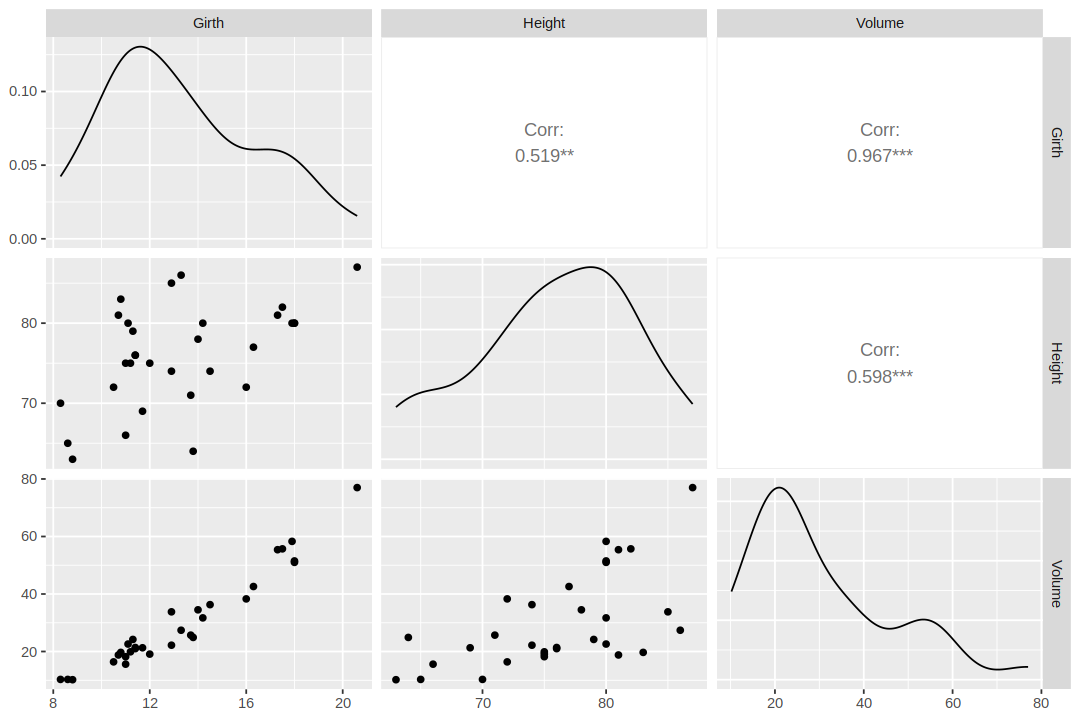

In [32]:
options(repr.plot.width = 9, repr.plot.height = 6)
data(trees)
ggpairs(trees)

## **Expected Outcomes and Significance**

What do you expect to find?
- Age and Chest Pain: The data may reveal patterns that suggest certain types of Chest Pain are more prevalent in specific Age groups.
  
- Cholesterol and Chest Pain: Higher Cholesterol levels may be associated with a higher likelihood of developing Chest Pain.
  
- Resting Blood Pressure and Chest Pain: Higher Resting Blood Pressure levels may be associated with a higher likelihood of developing a certain Chest Pain.


What impact could such findings have?
- Risk assessment: Healthcare providers can use these findings to improve risk assessment for patients.
  
- Treatment Strategies and Recommendations: Providing treatment strategies to specific patient groups based on the age and the level of cholesterol.
  
- Precaution: These findings can provide information to preventive care measures, such as suggesting cholesterol-low intervention for younger adults with a family history of heart disease.
  
- Developing new treatment and drugs: These findings can help to discover new treatments and drugs that can improve the treatments and prevention of disease.
  
- Reducing health care/operation costs: Through this finding more economical treatments can be found to help efficiently reduce health care costs.

What future questions could this lead to?
- How does the data from Hungary compare to one of the other data set from Switzerland, Cleveland and VA Long Beach
  
- One future question if we find a pattern between the types of chest pain and the 2 variables is, Why age/different levels of cholesterol result/resting blood pressure in different types of chest pains?

- Whether there are genetic factors that interact with age, cholesterol and resting blood pressure that affect the likelihood of chest pain?
  
- How do these associations affect long-term cardiovascular outcomes and outcomes in patients with chest pain?
